In [1]:
import os

import matplotlib.pyplot as plt

speech_sample_dir = 'speech_sample'

# preparation 2: read a wave file.
read signal data from a wav file without using any library.

In [2]:
wav_file = os.path.join(speech_sample_dir, 'A_a.wav')
print(wav_file)

speech_sample/A_a.wav


In [3]:
import scipy.signal as sig

# dt:信号
# N:窓サイズ
# max_m:最大ずらすサンプル数

# 自己相関関数
def auto_correlate(dt):
    cor = sig.correlate(dt,dt,mode="full")
    return cor[cor.size/2:]

# 相互相関関数
def correlate(dt):
    return sig.correlate(dt[:N+max_m],dt[:N],mode="valid")


In [4]:
import numpy as np
import scipy.signal as sig
import scipy.io.wavfile as scw
import matplotlib.pyplot as plt

# 自己相関関数
# r(m) = sum( x(n)*x(n+m) ) n=0~N-m-1, m=0~N-1
def auto_correlate(dt):
    cor = sig.correlate(dt,dt,mode="full")
    return cor[cor.size//2:]

# 初出peakの検出
def calc_first_peak_index(array):
    i = 0
    while array[i] > array[i+1]:
        i += 1
    while array[i] < array[i+1]:
        i += 1
    return i


16000 (1957,)
23
695.6521739130435


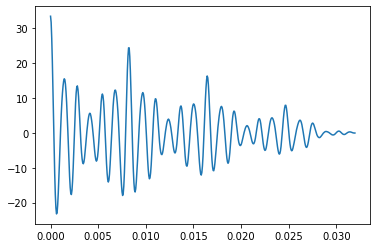

In [8]:
fs, dt = scw.read(wav_file)
dt = dt / (2 ** 15)
ts = 1 / fs

# 自己相関係数の計算
win_size = 2 ** 9 # 512
N = 2 ** 9
start = 1000

cor = auto_correlate(dt[start:start+N])
peak_index = calc_first_peak_index(cor)
print(peak_index)
freq = 1 / (peak_index * ts)
print(freq)

plt.plot(np.arange(cor.size) * ts, cor)
plt.show()